
# Visualization (20 points)

Visualization is a key component of exploration. You will generate some charts to get some intuition about the data. You can choose to use either Matplotlib or Seaborn for plotting. The default figures generated from Matplotlib might look a bit ugly. So you might want to try Seaborn to get better figures. The defaults in Seaborn are much saner and sometimes makes your life lot easier. Seaborn has number of styles - so feel free to experiment with them and choose the one you like. 


In [15]:
# These two lines ensure that all modules are reloaded every time a Python cell is executed.
# This allows us to modify some other Python file and immediately see the results
# instead of restarting the kernel and running every cell.
%load_ext autoreload
%autoreload 2

from ds5612_pa1 import t3_tasks


# Please read the code of get_fec_dataset to understand what it is doing
fec_df = t3_tasks.get_fec_dataset()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%matplotlib inline

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


## Task 4.1: Bar Charts (5 points)

Draw a "horizontal" bar chart that lists the top-10 states based on the TOTAL contribution they made to both candidates. For each state, draw two lines - one in blue for Obama and one in red for Romney. Display the proportion of the total contribution that came from the state. For eg, if Obama made 1 billion and TX gave 100 million of it, the proportion is 10%. 

Remember to set the titles for both axes and also the legend.

Your plot should look something like or better than this:

![T4.1](resources/t41.png) 

In [12]:
# Top 10 states for highest contribution
per_state_basis = fec_df.groupby(
    by="contbr_st"
)["contb_receipt_amt"].sum().sort_values(
    ascending=False
).head(10)
top_states = per_state_basis.index
contribution = []
(Obama, Romney) = fec_df[
    (fec_df["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"]))
].groupby(by="cand_nm")["contb_receipt_amt"].sum()
for state in top_states:
    res = np.array(fec_df[
        (fec_df["contbr_st"] == state) &
        fec_df["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])
    ].groupby(
        by="cand_nm"
    )["contb_receipt_amt"].sum())
    contribution.append(res)
contr_obama = np.array(contribution)[:, 0] / Obama
contr_romney = np.array(contribution)[:, 1] / Romney

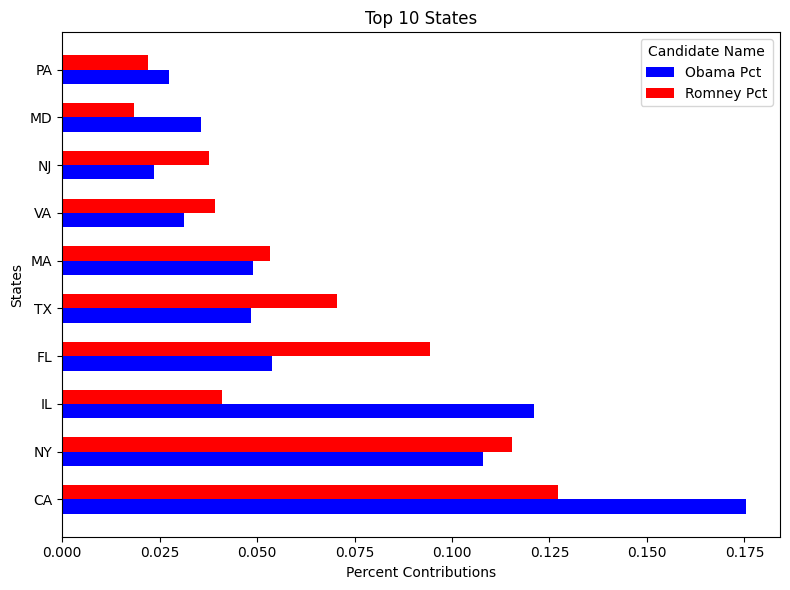

In [14]:
n_states = len(top_states)

bar_width = 0.3
y_positions = np.arange(n_states)

fig, ax = plt.subplots(figsize=(8,6))

ax.barh(y_positions - bar_width/2, contr_obama, bar_width, label="Obama Pct", color="blue")
ax.barh(y_positions + bar_width/2, contr_romney, bar_width, label="Romney Pct", color="red")

ax.set_yticks(y_positions)
ax.set_yticklabels(top_states)

ax.set_xlabel("Percent Contributions")
ax.set_ylabel("States")
ax.set_title("Top 10 States")

ax.legend(title="Candidate Name")

plt.tight_layout()
plt.show()

## Task 4.2: Line Charts (5 points)

Draw a line chart showing the CUMULATIVE campaign contribution of Obama and Romney varied every quarter. In other words, if Obama made X, Y, Z in first, second and third quarters of 2012, then plot X for first quarter, X+Y for second quarter and X+Y+Z for third quarter.

Use blue for Obama and red for Romney. This is a bit tricky because, you have to convert contribution date to quarter. The simplest solution is to create a new pandas column storing the quarter. 

Hint: The contb_receipt_dt field is already parsed as pandas datetime (see get_fec_dataset in t3_tasks.py). So find if there is a way to get the quarter from that date type. 

Remember to set the titles for both axes and also the legend.

Your plot should look something like or better than this:

![T4.2](resources/t42.png) 


In [65]:
def get_quater_from_df(fec: pd.DataFrame, candidate: str) -> list:
    start_date = fec["contb_receipt_dt"].min()
    start_date = np.datetime64(str(start_date.year) + "-01-01")

    # Final Date
    final_end_date = fec["contb_receipt_dt"].max()

    # Store
    total = 0
    quaterly = []
    while final_end_date >= start_date:
        total = total + fec[
            (fec["contb_receipt_dt"] >= start_date) &
            (fec["contb_receipt_dt"] <= (start_date + pd.DateOffset(months=3))) &
            (fec["cand_nm"] == candidate)
        ]["contb_receipt_amt"].sum() / 1e8
        quater = (pd.Timestamp(start_date).month // 3) + 1
        year = pd.Timestamp(start_date).year
        val = f"({year}, {quater})"
        # print(quater)
        temp = (val, float(total))
        start_date = start_date + pd.DateOffset(months=3)
        if total == 0:
            continue
        quaterly.append(temp)

        # update the time
    return quaterly

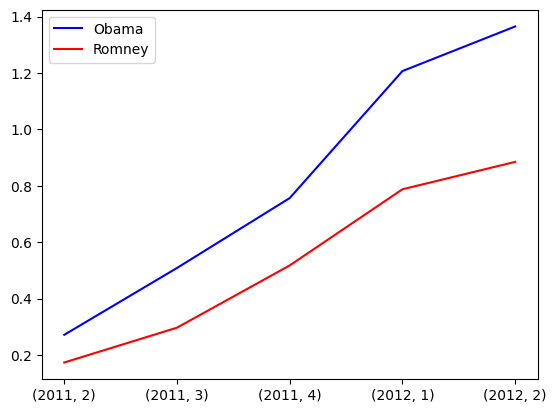

In [85]:
Obama_quarters = np.array(get_quater_from_df(fec_df, "Obama, Barack"))
Romney_quarters = np.array(get_quater_from_df(fec_df,"Romney, Mitt"))

# print(Obama_quarters)
# print(Romney_quarters)
# Obama_quarters.T[1].astype(float)
plt.plot(Obama_quarters.T[0], Obama_quarters.T[1].astype(float), color="blue", label="Obama")
plt.plot(Romney_quarters.T[0], Romney_quarters.T[1].astype(float), color="red", label="Romney")
plt.xlabel = "Quarters/Years"
plt.ylabel = "Per Quarter Contributions"

# plt.title(label="Cumulative Contributions")
plt.legend()
plt.show()


## Task 4.3: Histograms (5 points)

Let us do an side-by-side analysis of histogram/distribution of the contribution amount. Most citizens provide a small contribution while the affluent class might make a larger contribution. Studying the histogram will show which candidate gets most money from regular citizens.

We will set an arbitrary threshold of 2000. So we will remove all contributions > 2000. This should give a saner visualization without doing some tricks to handle outliers. 

Generate a side-by-side histogram for Obama and Romney. Use 50 bins. 

Use blue for Obama and red for Romney. This is a bit tricky because, you have to convert contribution date to quarter. The simplest solution is to create a new pandas column storing the quarter. 


Remember to set the titles for both axes and also the legend.

Your plot should look something like or better than this:

![T4.3](resources/t43.png)

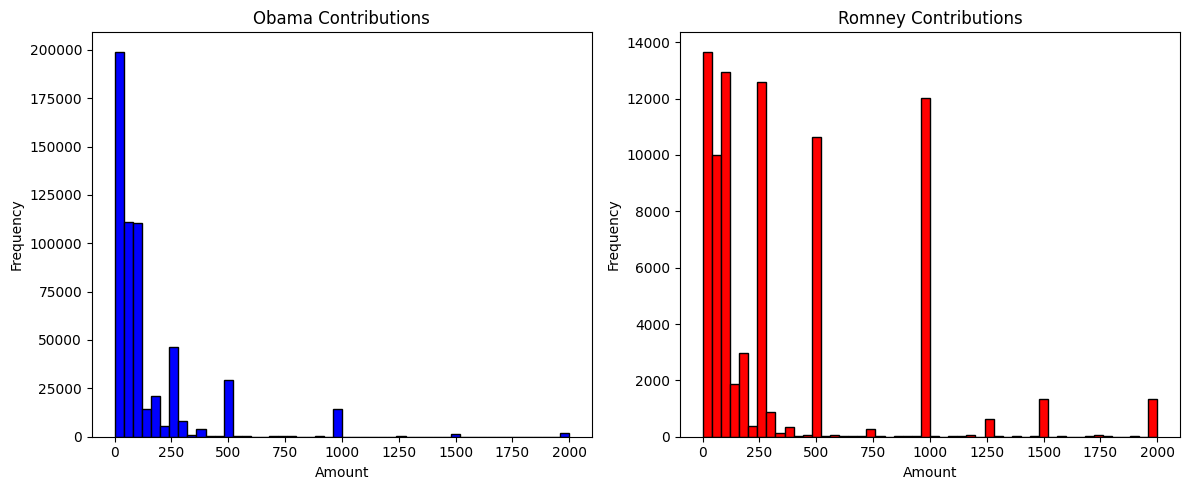

In [96]:
def get_values_per_cand(fec: pd.DataFrame, candidate: str) -> pd.Series:
    return fec[
        (fec["cand_nm"] == candidate) &
        (fec["contb_receipt_amt"] <= 2000)
    ]["contb_receipt_amt"]

obama_values = get_values_per_cand(fec_df, "Obama, Barack")
romney_values = get_values_per_cand(fec_df, "Romney, Mitt")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot Obama contributions histogram
ax1.hist(obama_values, bins=50, color="blue", edgecolor="black")
ax1.set_title("Obama Contributions")
ax1.set_xlabel("Amount")
ax1.set_ylabel("Frequency")

# Plot Romney contributions histogram
ax2.hist(romney_values, bins=50, color="red", edgecolor="black")
ax2.set_title("Romney Contributions")
ax2.set_xlabel("Amount")
ax2.set_ylabel("Frequency")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Task 4.4: Scatter Plots (5 points)

There is some kind of political polarization in US where some states favor democrats while others favor republicans. Let us do a simple chart to visualize this.

First, create a pandas groupby object where you compute the total contributions for Obama and Romney for each state. So after this, you will have a data frame with three columns cand_nm, contbr_st, and contb_receipt_amt where contb_receipt_amt gives the total amount of contributions for that state and that candidate. 

Next, we will visualize this data using scatter plot. As before, we will use blue for Obama and red for Romney. 

We will do one final post-processing. There are lot of states in US. So if you blindly plot the scatter plot, the names of the states will not be legible. So we do a simple trick where we "rotate" the name of the state by 90 degrees. 


Remember to set the titles for both axes and also the legend.

Your plot should look something like or better than this:

![T4.4](resources/t44.png)

In [117]:
states_obama = (fec_df[fec_df["cand_nm"] == "Obama, Barack"]
                .groupby("contbr_st")["contb_receipt_amt"]
                .sum() / 1e7).index
Obama = (fec_df[fec_df["cand_nm"] == "Obama, Barack"]
         .groupby("contbr_st")["contb_receipt_amt"]
         .sum() / 1e7).to_numpy()
Romney = (fec_df[fec_df["cand_nm"] == "Romney, Mitt"]
          .groupby("contbr_st")["contb_receipt_amt"]
          .sum() / 1e7).to_numpy()
states_romney = (fec_df[fec_df["cand_nm"] == "Romney, Mitt"]
                 .groupby("contbr_st")["contb_receipt_amt"]
                 .sum() / 1e7).index

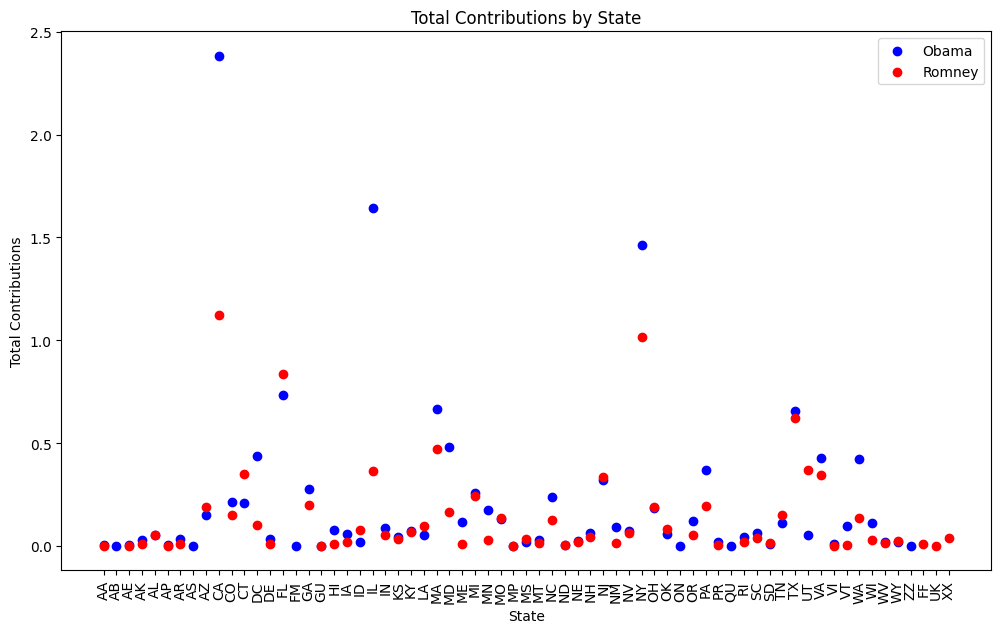

In [118]:
# states_romney
fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(states_obama, Obama, color="blue", label="Obama")
ax.scatter(states_romney, Romney, color="red", label="Romney")
plt.xticks(rotation=90)
ax.set_xlabel("State")
ax.set_ylabel("Total Contributions")
ax.set_title("Total Contributions by State")
ax.legend()
plt.show()